# 1. LSTM recap
<img src = "LSTM (1).png" style="width:450;height:300px;">
lstm은 위의 그림과 같은 구조로 되어있고, 순환신경망입니다. 기억나져?

# 2. 필요한 module 불러오기

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# 3.
우리는 IMDB 데이터를 가지고 **감성분석을 하는 LSTM 모델**을 만들어보려고 합니다.  
사실 LSTM은 이런 간단한 문제 보다는 더 복잡한 문제에 적합한 모델이지만,  
우리 LSTM 어려워 하기도 했고 해서 간단하게 LSTM 한 번 사용해 본다는 거에 의의를 둬볼게요!  
  
review에 labeling을 하려고 합니다.
- 0 : 부정
- 1 : 약간 부정
- 2 : 보통
- 3 : 약간 긍정
- 4 : 긍정  
이 다섯가지 단계로 labeling하려고 하고, 사용할 데이터는 첨부된 데이터입니다.

# (1) 데이터 확인

In [2]:
df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


train data입니다. 150,000개가 넘는 sample들이 있고, phrase에 있는 데이터들이 다 완성되어 있지 않은 경우도 있고 반복적인 단어들이 있다는 것도 확인할 수 있습니다.

In [3]:
df_test = pd.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


pharse ID와 sentence ID는 이게 kaggle에서 가져온 데이터라서 submission 했을 때 채점용으로 있는 거예요! 신경쓰지 않아도 됩니다.

# (2) 전처리

우리가 가지고 온 데이터는 ASCII문자인데, 얘는 컴퓨터에 의해서 16진수로 해석됩니다. 그래서 'A'와 'a'를 다르다고 해석하게 됩니다. 이를 방지하기 위해서 모든 단어를 소문자로 바꾸려고 합니다.  
뿐만 아니라, 'happy.'는 'happy'와 다르게 인식되는데요. 왜냐하면 뒤에 '.'이 붙어있기 때문입니다. 이것도 방지해주려고 합니다.  
영어라서 말 줄임들이 있겠죠? (I am = I'm으로!) 이런 것도 다 고쳐주려고 합니다.

- i'm --> 'i am'
- 're --> ' are'
- let's --> 'let us'
- 's --> ' is'
- 've --> ' have'
- can't --> 'can not'
- cannot --> 'can not'
- shan't --> 'shall not'
- n't -->' not'
- 'll -->' will'
- 'd -->' would'
- 'scuse --> 'excuse'
- , --> ' ,'
- . -->' .'
- ! --> ' !'
- ? -> ' ?'
- \s+ --> ' '

### (2) - 1

In [4]:
replace_list = {r"i'm" : 'i am', # 문자열 앞에 r을 붙이는 이유가 궁금하신 분은 정규표현식 검색 ㄱㄱ
               '.' : ' .',
               r"'re" : ' are',
               r"let's" : 'let us',
               r"'s" : "is",
               r"'ve" : "have",
               r"can't" : "can not",
               r"shan't" : "shall not",
               r"n't" : " not",
               r"'ll" : " will",
               r"'d" : " would",
               r"'scuse" : 'excuse',
               ',' : ' ,',
               '!' : ' !',
               '?' : ' ?',
               r'\s+' : ''}
# 두개만 예를 들어서 드릴게요. 나머지는 채워넣어주세요!

In [5]:
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

### (2) - 2

### 전처리 함수 적용
apply+lambda를 이용해서 df_train의 'Phrse' 열에 적용해주세요

In [6]:
df_train['Phrase'] = df_train['Phrase'].apply(lambda x: clean_text(x))

max phrase len: 53


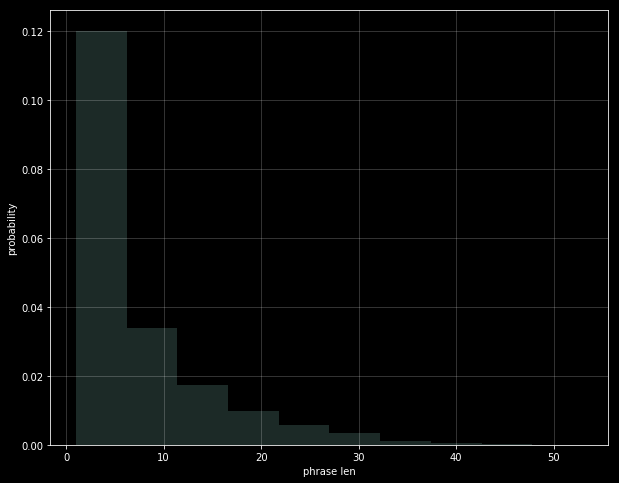

In [7]:
phrase_len = df_train['Phrase'].apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

이 부분 관련해서 제가 잘못 설명한게 있어서 여기서 정정할게요!  
RNN, LSTM류는 입력 데이터의 길이가 variable해도 괜찮다고 했는데  
여기까진 맞았는데? --> 입력 길이가 다른걸 모두 padding으로 같은 길이로 맞춰준다고 해요!  

예를 들어 문장 길이 64 짜리, 문장길이 30짜리 두 개를 input으로 넣는다고 하면  
가장 긴 길이인 64에 맞춰서 문장길이 30짜리 뒤에 0padding을 넣어서 64로 맞춰준대요 (주로 뒤에 넣는다고 합니다)  
뒤에 넣는다고 했을 때 그러면 장기 의존성 문제는? 데이터의 연산은? 하는 궁금증이 생길 수 있는데 차례대로 설명해볼게요  
  
    (1) 장기의존성 문제:
        zero padding이 시작되는 부분부터 eos (end of sequence)를 출력으로 내서 그 이후는 연산하지 않아서 장기 의존성 문제가 생기지 않습니다.
    (2) 데이터 연산량 문제:
        위와 같은 이유로 데이터 연산량에 영향 미치지 않습니다! 덧붙여 가지고 있는 데이터에 0로 의미 없는 데이터가 많은 거는 문제가 안 된다고 합니다.  
        데이터의 크기가 커서 문제가 생기는 건 -> 연산량이 많아서 문제가 생기는거지, 가지고 있는 데이터 자체의 크기가 크다고 문제가 생기는 건 아니래요
        

위의 (1)번에서 시행하는 방법 때문에 제가 인풋 데이터가 다를 때 zero padding을 넣지 않는다고 생각했던 것 같아요! 죄송합니다 ㅜㅜ  
다시 한 번 정리하자면  

(1) input 데이터의 길이를 모두 가장 긴 문장의 길이 만큼으로 채워준다.  
ex ) 2 24 3 15 0 0 0 0 0 0 0   
      1 30 5 12 1 2 13 15 16 17 이런식으로!       

(2) 0이 시작되는 부분부터는 eos를 출력으로 내서 연산하지 않는다.  
--> 쓸데 없는 연산 X

### (2) - 3

target label을 분리해주세요.

In [8]:
y_train = df_train['Sentiment']

# (3) 단어 임베딩

컴퓨터는 word를 이해하지 못해서 숫자로 바꿔줘야 합니다. 이 작업을 '토큰화', tokenizer라고 하는데요. 자세한 내용은 3주차에 배워 볼거예요!

In [9]:
X_train = df_train['Phrase']
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

# (4) 모델링

### (4)-1
Sequential 함수를 이용해서 모델 지정해주세요.
우리가 Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D를 불러왔으니 얘네를 사용해야 겠죠? add하는 순서를 정해드릴게요.  
dropout 비율은 0.3으로 해주세요.
- Embedding
- SpatialDropout1D
- LSTM
- Dense
- Dropout # Overfitting을 방지하기 위해 dropout layer을 사용했습니다.
- Dense

In [10]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(80))
model_lstm.add(Dense(50))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5))

W0322 17:59:49.663894 23496 deprecation.py:506] From C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0322 17:59:49.709773 23496 deprecation.py:506] From C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### (4)-2 Compile

loss는 적절한 걸로, optimizer은 adam, metrics는 accuracy로 설정해주세요.

In [11]:
model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# (5) FIT

validation_split을 사용해서 train / val data set을 나눠주세요! 우리 따로 test 데이터가 없어요  
참고로 밑에 코드 시간 오래걸리니까 첫번째 돌렸을 때  
loss:1.1965, accuracy:0.5363, val_loss=1.0143 안 나오면 멈추고 다시!

In [12]:
X_train.shape, y_train.shape

((156060, 53), (156060, 5))

In [13]:
history = model_lstm.fit(x=X_train, y=y_train,
    validation_split=0.2,
    epochs = 5,
    batch_size = 512
)

W0322 17:59:50.177523 23496 deprecation.py:323] From C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 124848 samples, validate on 31212 samples
Epoch 1/5
124848/124848 [==============================] - 111s 887us/sample - loss: 2.1687 - acc: 0.3572 - val_loss: 1.3386 - val_acc: 0.4922
Epoch 2/5
124848/124848 [==============================] - 108s 863us/sample - loss: 1.3732 - acc: 0.5143 - val_loss: 1.3232 - val_acc: 0.4922
Epoch 3/5
124848/124848 [==============================] - 124s 994us/sample - loss: 1.3360 - acc: 0.5144 - val_loss: 1.3150 - val_acc: 0.4922
Epoch 4/5
124848/124848 [==============================] - 125s 997us/sample - loss: 1.3152 - acc: 0.5144 - val_loss: 1.3010 - val_acc: 0.4922
Epoch 5/5
124848/124848 [==============================] - 117s 940us/sample - loss: 1.2844 - acc: 0.5144 - val_loss: 1.2739 - val_acc: 0.4922


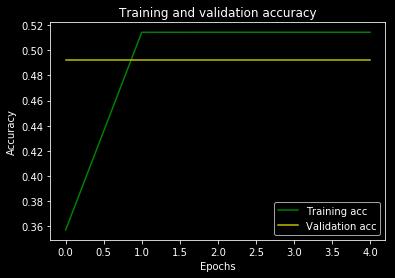

In [14]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(acc, 'g', label='Training acc')
plt.plot(val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()